# Rendering Objects for YCB Dataset

In [1]:
%matplotlib inline
import bpy

import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Helpful Image Viewing Functions

In [2]:
from object_pose_utils.utils.image_preprocessing import transparentOverlay
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    
def torch2Img(img, show = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img).copy()
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img[:,:,:3] = disp_img[:,:,:3] * std + mean
    if(disp_img.shape[2] == 4):
        disp_img[:,:,3] *= 255
        disp_img = transparentOverlay(disp_img)
    return disp_img
    
def imshowTorch(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    if(show):
        plt.show()

def plotImageScatter(img, choose, show = True):
    coords = np.unravel_index(choose, img.shape[:2])    
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))    
    plt.scatter(coords[1], coords[0], 50)
    #plt.colorbar()
    if(show):
        plt.show()

## YCB to Render Transform

In [14]:
from quat_math import euler_matrix, quaternion_matrix, quaternion_about_axis

def getYCBTransform(q, t=[0,0,1]):
    trans_mat = quaternion_matrix(q)
    ycb_mat = euler_matrix(-np.pi/2,0,0)
    trans_mat = trans_mat.dot(ycb_mat)
    trans_mat[:3,3] = t
    return trans_mat

## Location of YCB Dataset

In [3]:
#dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
dataset_root = '/home/bokorn/data/ycb/debug'

## Select Object Indices of Interest

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |


In [4]:
object_list = [14]
#object_list = list(range(1,22))

## Select Dataset
Modes include train, syn, grid, valid, test and can be concatinated with "\_", e.g. "train\_syn"

In [5]:
mode = "train"

## Select Output Data Types

In [33]:
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_MASKED_CROPPED, 
                 otypes.DEPTH_IMAGE_MASKED_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]

## Load Dataset

In [34]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer

with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')

dataset = YCBDataset(dataset_root, mode=mode, 
                     object_list = object_list, 
                     output_data = output_format, 
                     postprocessors = [ImageNormalizer],
                     image_size = [640, 480], num_points=1000)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)


## Setup Renderer

In [85]:
from model_renderer.pose_renderer import BpyRenderer
from generic_pose.datasets.ycb_dataset import ycbRenderTransform

renderer = BpyRenderer(transform_func = ycbRenderTransform)

fx = 1066.778
fy = 1067.487
px = 312.9869
py = 241.3109
camera_dist = 0.33

renderer.setCameraMatrix(fx, fy, px, py, 640, 480)
renderer.setDepth()
model_cls = None

## Sample Data

In [86]:
for data in dataloader:
    obj, q, im, dph, pts, chs = data
    break

print('{} at rotation {}'.format(classes[int(obj)], np.round(to_np(q)[0], 2)))

025_mug at rotation [ 0.79 -0.39  0.26  0.4 ]


## Load Model

In [87]:
renderer.deleteAll()
if(model_cls != classes[int(obj)]):
    model_cls = classes[int(obj)]
    model_filename = '{}/models/{}/textured.obj'.format(dataset_root, model_cls)
    renderer.deleteAll()
    renderer.loadModel(model_filename, emit = 0.5)

(  0.0003 sec |   0.0003 sec) Importing OBJ '/home/bokorn/data/ycb/debug/models/025_mug/textured.obj'...
  (  0.0009 sec |   0.0005 sec) Parsing OBJ file...
    (  6.7924 sec |   6.7915 sec) Done, loading materials and images...
    (  6.7932 sec |   6.7923 sec) Done, building geometries (verts:262140 faces:524288 materials: 1 smoothgroups:1) ...
    ( 16.7481 sec |  16.7471 sec) Done.
  ( 16.7484 sec |  16.7480 sec) Finished importing: '/home/bokorn/data/ycb/debug/models/025_mug/textured.obj'
Progress: 100.00%



## Render Object

In [88]:
from object_pose_utils.datasets.pose_dataset import processDepthImage, processImage
from object_pose_utils.datasets.image_processing import get_bbox_label, norm

trans_mat = getYCBTransform(q[0], [0,0,1])
image, depth = renderer.renderTrans(trans_mat)
image[:,:,:3] = cv2.cvtColor(image[:,:,:3], cv2.COLOR_BGR2RGB)
depth[depth > 1000] = 0
depth = depth*10000

meta_data_rend = {}
meta_data_rend['transform_mat'] = trans_mat
meta_data_rend['camera_scale'] = 10000
meta_data_rend['camera_fx'] = fx
meta_data_rend['camera_fy'] = fy
meta_data_rend['camera_cx'] = px
meta_data_rend['camera_cy'] = py
meta_data_rend['mask'] = image[:,:,3] > 128
meta_data_rend['bbox'] = get_bbox_label(meta_data_rend['mask'])

im_rend = norm(processImage(image[:,:,:3], meta_data_rend, otypes.IMAGE_MASKED_CROPPED))
dph_rend = processDepthImage(depth, meta_data_rend, otypes.DEPTH_IMAGE_MASKED_CROPPED)[0]
pts_rend, chs_rend = processDepthImage(depth, meta_data_rend, otypes.DEPTH_POINTS_MASKED_AND_INDEXES)



### Image 

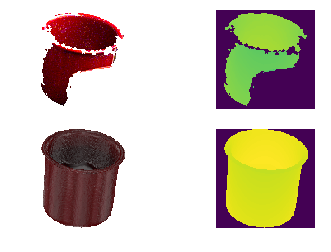

In [90]:
plt.subplot(221)
imshowTorch(im[0], show=False)
plt.subplot(222)
imshow(dph[0], show=False)
plt.subplot(223)
imshowTorch(im_rend, show=False)
plt.subplot(224)
imshow(dph_rend, show=False)
plt.show()

### Samples 

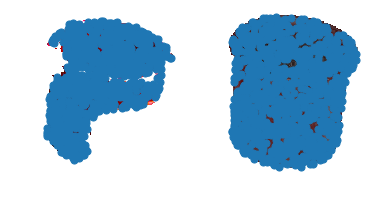

In [91]:
plt.subplot(121)
plotImageScatter(torch2Img(im), to_np(chs), show=False)
plt.subplot(122)
plotImageScatter(torch2Img(im_rend), to_np(chs_rend), show=False)
plt.show()

### Points

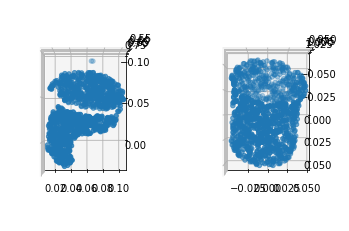

In [93]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
pts_np = to_np(pts[0])
ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
ax.view_init(270, -90)
ax = fig.add_subplot(122, projection='3d')
pts_np = to_np(pts_rend)
ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
ax.view_init(270, -90)
plt.show()